Analyses properties of decorrelation and whitening methods for decorrelated networks

In [1]:
import numpy as np
import torch
import torch.nn as nn
from decorrelation.decorrelation import Decorrelation, DecorLinear, DecorConv2d
import matplotlib.pyplot as plt
import matplotlib
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from decorrelation.utils import decor_train
import argparse
from decorrelation.plotting import *

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5), (0.5)),
        # torch.flatten # not necessary but useful for debugging
        ])

train_data = MNIST(root='~/Data', train=True, download=True, transform=transform)
train_data = Subset(train_data, np.random.permutation(len(train_data.data))[:1000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

In [3]:
args = argparse.Namespace(lr=0.0, kappa=1e-2, decor_lr=1e-1, epochs=20)

model = Decorrelation(784, decor_lr=args.decor_lr, kappa=args.kappa).to(device)

lossfun = lambda x, y: nn.Parameter(torch.zeros(1, device=device, dtype=float), requires_grad=True)

res = decor_train(args, model, lossfun, train_loader, device=device)

epoch 0  	time:0.000 s	bp loss: 0.000000	decorrelation loss: 6.593070	test loss: 0.000000
epoch 1  	time:0.546 s	bp loss: 0.000000	decorrelation loss: 2.392300	test loss: 0.000000
epoch 2  	time:0.536 s	bp loss: 0.000000	decorrelation loss: 0.515656	test loss: 0.000000
epoch 3  	time:0.541 s	bp loss: 0.000000	decorrelation loss: 0.260103	test loss: 0.000000
epoch 4  	time:0.536 s	bp loss: 0.000000	decorrelation loss: 0.174338	test loss: 0.000000
epoch 5  	time:0.531 s	bp loss: 0.000000	decorrelation loss: 0.134951	test loss: 0.000000
epoch 6  	time:0.517 s	bp loss: 0.000000	decorrelation loss: 0.111709	test loss: 0.000000
epoch 7  	time:0.532 s	bp loss: 0.000000	decorrelation loss: 0.096316	test loss: 0.000000
epoch 8  	time:0.521 s	bp loss: 0.000000	decorrelation loss: 0.088545	test loss: 0.000000
epoch 9  	time:0.516 s	bp loss: 0.000000	decorrelation loss: 0.083344	test loss: 0.000000
epoch 10 	time:0.532 s	bp loss: 0.000000	decorrelation loss: 0.079147	test loss: 0.000000
epoch 11 	

layer 1:

mean covariance before decorrelation: 0.56
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.02
mean variance after decorrelation: 0.41



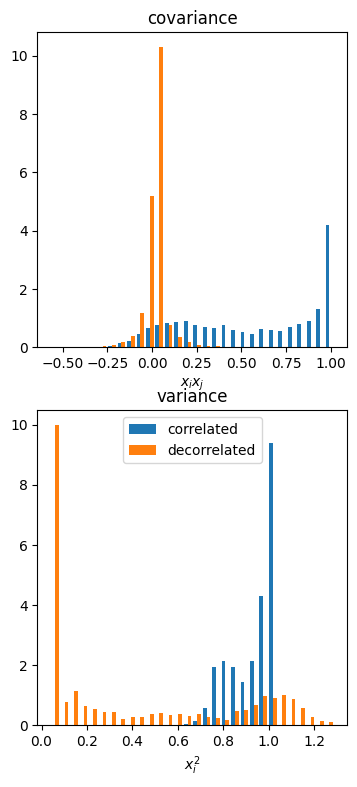

In [4]:
init_model = Decorrelation(784, decor_lr=args.decor_lr, kappa=args.kappa).to(device)
plot_correlations(init_model, model, train_loader, device=device)

In [9]:
args = argparse.Namespace(lr=1e-4, decor_lr=1e-1, kappa=1e-2, epochs=10)

class Model(nn.Sequential):
    def __init__(self, in_features, args):
        super().__init__(DecorLinear(in_features, 10, decor_lr=args.decor_lr, kappa=args.kappa))

    def forward(self, x):
        return super().forward(x.view(len(x), -1))
    
model = Model(784, args).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

res = decor_train(args, model, lossfun, train_loader, device=device)

epoch 0  	time:0.000 s	bp loss: 2.603207	decorrelation loss: 6.585071	test loss: 0.000000
epoch 1  	time:0.533 s	bp loss: 2.460017	decorrelation loss: 2.388216	test loss: 0.000000
epoch 2  	time:0.553 s	bp loss: 2.315653	decorrelation loss: 0.515794	test loss: 0.000000
epoch 3  	time:0.537 s	bp loss: 2.201763	decorrelation loss: 0.260769	test loss: 0.000000
epoch 4  	time:0.531 s	bp loss: 2.103223	decorrelation loss: 0.173301	test loss: 0.000000
epoch 5  	time:0.533 s	bp loss: 2.009119	decorrelation loss: 0.132759	test loss: 0.000000
epoch 6  	time:0.531 s	bp loss: 1.918119	decorrelation loss: 0.111144	test loss: 0.000000
epoch 7  	time:0.534 s	bp loss: 1.834263	decorrelation loss: 0.097718	test loss: 0.000000
epoch 8  	time:0.529 s	bp loss: 1.753431	decorrelation loss: 0.088499	test loss: 0.000000
epoch 9  	time:0.542 s	bp loss: 1.683609	decorrelation loss: 0.083408	test loss: 0.000000
epoch 10 	time:0.528 s	bp loss: 1.608062	decorrelation loss: 0.080303	test loss: 0.000000


layer 1:

mean covariance before decorrelation: 0.56
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.03
mean variance after decorrelation: 0.34



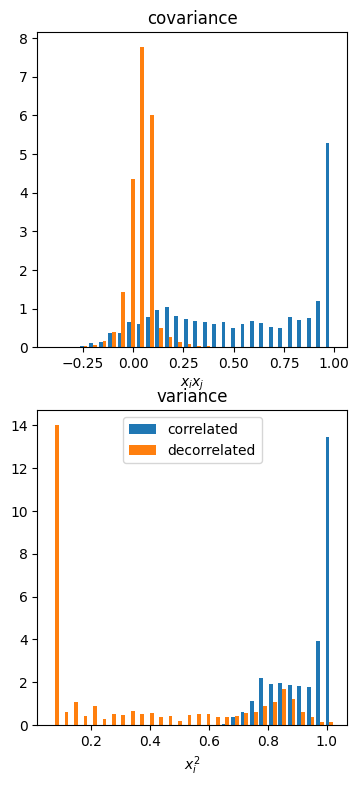

In [6]:
init_model = Model(784, args).to(device)
plot_correlations(init_model, model, train_loader, device=device)

In [7]:
args = argparse.Namespace(lr=1e-4, decor_lr=1e-1, kappa=1e-2, epochs=10)

class Model(nn.Sequential):
    def __init__(self, in_features, args):
        super().__init__(DecorLinear(in_features, 100, decor_lr=args.decor_lr, kappa=args.kappa),
                        nn.LeakyReLU(),
                        DecorLinear(100, 10, decor_lr=args.decor_lr, kappa=args.kappa)
                        )

    def forward(self, x):
        return super().forward(x.view(len(x), -1))

# class Model(nn.Sequential):
#     def __init__(self, in_features, eta, whiten):
#         super().__init__(Decorrelation(in_features, bias=False, eta=eta, whiten=whiten),
#                         nn.BatchNorm1d(in_features),
#                         nn.Linear(in_features, 100),
#                         nn.LeakyReLU(),
#                         Decorrelation(100, bias=False, eta=eta, whiten=whiten),
#                         nn.BatchNorm1d(100),
#                         nn.Linear(100, 10)
#                         )
    
model = Model(784, args).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

res = decor_train(args, model, lossfun, train_loader, device=device)

epoch 0  	time:0.000 s	bp loss: 2.534098	decorrelation loss: 6.847097	test loss: 0.000000
epoch 1  	time:0.573 s	bp loss: 2.433265	decorrelation loss: 2.466475	test loss: 0.000000
epoch 2  	time:0.556 s	bp loss: 2.282260	decorrelation loss: 0.551925	test loss: 0.000000
epoch 3  	time:0.554 s	bp loss: 2.137580	decorrelation loss: 0.312660	test loss: 0.000000
epoch 4  	time:0.568 s	bp loss: 1.971269	decorrelation loss: 0.255330	test loss: 0.000000
epoch 5  	time:0.550 s	bp loss: 1.799047	decorrelation loss: 0.251012	test loss: 0.000000
epoch 6  	time:0.561 s	bp loss: 1.626749	decorrelation loss: 0.261441	test loss: 0.000000
epoch 7  	time:0.572 s	bp loss: 1.475312	decorrelation loss: 0.272193	test loss: 0.000000
epoch 8  	time:0.553 s	bp loss: 1.348352	decorrelation loss: 0.273441	test loss: 0.000000
epoch 9  	time:0.547 s	bp loss: 1.229840	decorrelation loss: 0.283207	test loss: 0.000000
epoch 10 	time:0.547 s	bp loss: 1.123972	decorrelation loss: 0.280331	test loss: 0.000000


layer 1:

mean covariance before decorrelation: 0.56
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.03
mean variance after decorrelation: 0.36

layer 2:

mean covariance before decorrelation: 0.05
mean variance before decorrelation: 0.17

mean covariance after decorrelation: 0.07
mean variance after decorrelation: 0.38



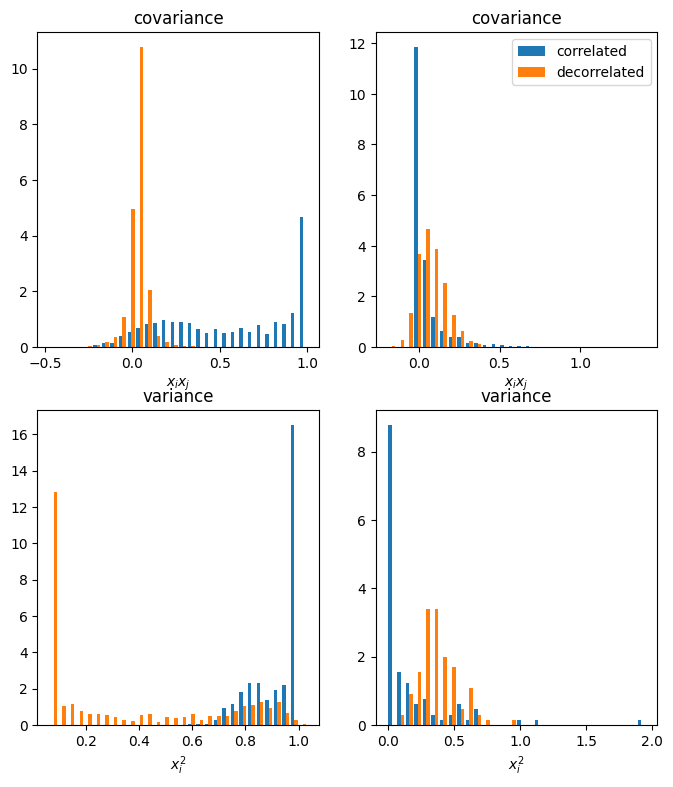

In [8]:
init_model = Model(784, args).to(device)
plot_correlations(init_model, model, train_loader, device=device)